# The Cerebro 🧠

This notebook implements the Diffusion Denoise Probabilistic Model (DDPM) notebook from class with an added conditional class. The purpose of this addition is to sample images by inputting different labels as conditions, allowing the creation of images that combine these classes. The intention is to explore improved methods for manipulating an unlabeled dataset.

The approach for integrating the conditional class is based on a [tutorial](https://huggingface.co/learn/diffusion-course/en/unit2/3) from Hugging Face, which uses Torch; this version has been adapted for Keras.

A DDPM model learns to generate images by denoising through two processes, each of which is a Markov Chain: the forward process and the reverse process.


##The Dataset

The dataset consists of images from an MRI that I had done in 2021. The MRI was provided to me as short videos, which I combined, trimmed, and exported as JPEG files using Adobe Premiere Pro. In total, there are 7,903 images, originally sized 310 x 322 pixels.


##The Workflow

**Gaussian noise**
1. Use \(x_t\) (our noisy sample) and the predicted noise to reconstruct \(x_0\).
2. Mix the reconstructed \(x_0\) with \(x_t\) using the appropriate scaling.
3. Reinject some noise (sampling with reparameterization/Langevin dynamics).


**Nonzero Mask**  
The nonzero mask is set to zero when \( t \) is zero and one otherwise. This functionality effectively turns the noise to zero for timestep zero, resulting in the final generated image.


**Time Embedding**  
This employs the sinusoidal embedding scheme. To enable the model to utilize the sequence's order, we must incorporate information about the relative or absolute positions of the tokens within the sequence.


**Multilayer Perceptron**  
Processes the time embedding and returns an output tensor with the shape (B, units), where "units" is a parameter that specifies the size of the output feature space.


**Class Conditional Generation**  
Generates dense embedding vectors for categorical class labels. These embeddings condition the model's output based on class information.


**Model Construction**  
This phase involves defining a U-Net neural network that incorporates time and class conditioning.
The inputs for this model are: [image_input, time_input, class_input], and it outputs a reconstructed image tensor with dimensions (img_size, img_size, 3).


**Self-Attention Mechanism**  
The self-attention mechanism computes attention scores to assess the relevance of different spatial regions.  
- **AttentionBlock**: Concentrates on significant spatial relationships.  
- **ResidualBlock**: Facilitates efficient feature transformation while preserving information.  
- **DownSample/UpSample**: Manages resolution changes during encoding and decoding.


**Diffusion Model**  
This model implements a denoising diffusion probabilistic model (DDPM).  
- **EMA Model**: Stabilizes training by averaging weights over time, leading to smoother predictions.  
- **Gaussian Diffusion Utility**: Manages mathematical operations related to adding and removing noise.  
- **Noise Prediction Loss**: Trains the network to accurately predict noise.


**Building the U-Net Model**  
This step initializes the components of the diffusion model and compiles it for training. The key components include:  
- **Network**: The primary U-Net model for noise prediction.  
- **EMA Network**: A duplicate of the model, ensuring stability during inference with EMA.  
- **GDF Utility**: Handles the Gaussian noise diffusion process.  
- **DiffusionModel**: Integrates all components into a cohesive trainable model.  
- **Compilation**: Specifies the loss function (Mean Squared Error) and optimizer (Adam) for training the model to perform denoising tasks.


**Feeding Labels**  
After training, the model receives labels to generate labeled images from the diffusion model, enabling visualization of the results.


**One Image = Two Classes**

Uses linear interpolation method between two classes to create a mix conditioning then generate one image combining two classes.


In [1]:
#@title Libraries

import math
import tqdm
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from PIL import Image
from IPython.display import Video, display
import re

In [2]:
#@title connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Download Dataset to colab
!gdown 14WniNyrIHmWGWJ7tGsZ7jsu9EVJC8h95

Downloading...
From (original): https://drive.google.com/uc?id=14WniNyrIHmWGWJ7tGsZ7jsu9EVJC8h95
From (redirected): https://drive.google.com/uc?id=14WniNyrIHmWGWJ7tGsZ7jsu9EVJC8h95&confirm=t&uuid=8771cbfc-5239-492b-aa42-3c62ae6a6de2
To: /content/mri_dataset.zip
100% 253M/253M [00:02<00:00, 120MB/s] 


In [4]:
#@title Unzip
!unzip /content/mri_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: mri_dataset/Sequence 012903.jpg  
  inflating: mri_dataset/Sequence 012904.jpg  
  inflating: mri_dataset/Sequence 012905.jpg  
  inflating: mri_dataset/Sequence 012906.jpg  
  inflating: mri_dataset/Sequence 012907.jpg  
  inflating: mri_dataset/Sequence 012908.jpg  
  inflating: mri_dataset/Sequence 012909.jpg  
  inflating: mri_dataset/Sequence 012910.jpg  
  inflating: mri_dataset/Sequence 012911.jpg  
  inflating: mri_dataset/Sequence 012912.jpg  
  inflating: mri_dataset/Sequence 012913.jpg  
  inflating: mri_dataset/Sequence 012914.jpg  
  inflating: mri_dataset/Sequence 012915.jpg  
  inflating: mri_dataset/Sequence 012916.jpg  
  inflating: mri_dataset/Sequence 012917.jpg  
  inflating: mri_dataset/Sequence 012918.jpg  
  inflating: mri_dataset/Sequence 012919.jpg  
  inflating: mri_dataset/Sequence 012920.jpg  
  inflating: mri_dataset/Sequence 012921.jpg  
  inflating: mri_dataset/Sequence 012922.jpg  
  inflati

In [5]:
#@title Training parameters
batch_size = 64
num_epochs = 100  # Enough for the size of the dataset.
total_timesteps = 1000  # Common/reasonable quantity of steps for a DDPM model.

# Normalization and optimization parameters
norm_groups = 8  # More will cost me more.
learning_rate = 2e-4

# Image-related parameters
img_size = 128
img_channels = 3

# Value clipping parameters
clip_min = -1.0
clip_max = 1.0

# Model architecture parameters
first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2

# Dataset parameters
dataset_name = "MRI_dataset"
dataset_path = "/content/mri_dataset"
splits = ["train"]


In [6]:
#@title Image Processing

def augment(img):
    """Flips an image left/right randomly."""
    return tf.image.random_flip_left_right(img)


def resize_and_rescale(img, size):
    """Resize the image to the desired size first and then
    rescale the pixel values in the range [-1.0, 1.0].

    Args:
        img: Image tensor
        size: Desired image size for resizing
    Returns:
        Resized and rescaled image tensor
    """

    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)

    img = tf.image.crop_to_bounding_box(
        img,
        (height - crop_size) // 2, # top left corner (x & y) (to center,
        (width - crop_size) // 2,  # get half of the remainder, i.e. 'margins')
        crop_size,                 # width
        crop_size,                 # height
    )

    # Resize
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size=size, antialias=True)

    # Rescale the pixel values
    img = img / 127.5 - 1.0
    img = tf.clip_by_value(img, clip_min, clip_max)
    return img

def train_preprocessing(image_path): # changed parameter name to reflect function being applied to file paths
    """Loads an image from a file path, applies preprocessing and data augmentation."""
    image = tf.io.read_file(image_path) # Reads the image file
    image = tf.image.decode_jpeg(image, channels=3) # Decodes the image, assuming it is JPEG, and forces 3 channels
    image = resize_and_rescale(image, size=(img_size, img_size))
    print(f"Preprocessed image shape: {image.shape}")
    image = augment(image)
    return image

# Create dataset
file_pattern = f"{dataset_path}/*"
ds = tf.data.Dataset.list_files(file_pattern, shuffle=True)

# Check the content of ds
for file_path in ds.take(5):
    print(file_path)

train_ds = (
    ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)



tf.Tensor(b'/content/mri_dataset/Sequence 016969.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/mri_dataset/Sequence 017775.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/mri_dataset/Sequence 012363.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/mri_dataset/Sequence 011694.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/mri_dataset/Sequence 014594.jpg', shape=(), dtype=string)
Preprocessed image shape: (128, 128, 3)


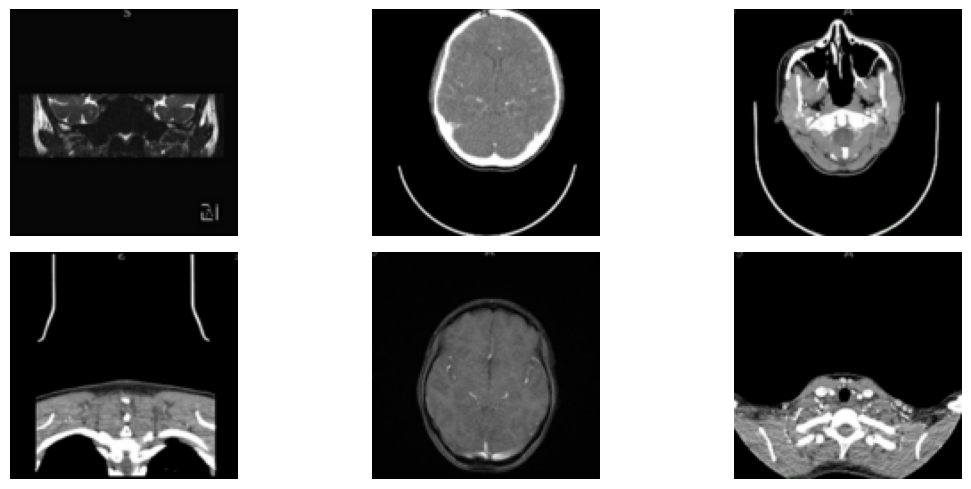

In [7]:
#@title Plot a few images from dataset

def plot_images(images, num_rows=2, num_cols=3, figsize=(12, 5)):

    assert len(images) <= num_rows * num_cols, f"Too many images ({len(images)}) for {num_rows} rows x {num_cols} cols ({num_rows * num_cols} slots): please increase either the rows or the columns!"

    # from [-1,1] to [0,255]
    images = tf.clip_by_value(images * 127.5 + 127.5, 0.0, 255.0).numpy().astype(np.uint8)

    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    # turn off all axes no matter how many images we have
    [a.axis("off") for row in ax for a in row]
    # display images
    for i, image in enumerate(images):
        if num_rows == 1: # if only one row
            ax[i].imshow(image)
        else:
            ax[i // num_cols, i % num_cols].imshow(image)

    plt.tight_layout()
    plt.show()

for batch in train_ds.take(1):
    plot_images(batch[:6])

In [8]:
#@title Gaussian diffusion

class GaussianDiffusion:
    """Gaussian diffusion utility.

    Note:
        q refers to the forward process (noising, fixed)
        p refers to the reversed process (denoising, learnt)
        In the docstrings, B: batch_size, W: width, H: height, C: channels

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):

        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        self.num_timesteps = int(timesteps)

        # ----------------------------------------------------------------------
        # PRECOMPUTED VALUES (at all time steps)
        # for diffusion q(x_t | x_{t-1}) and others

        def tf_const(x):
            return tf.constant(x, dtype=tf.float32)

        # Linear variance schedule (float64 for better precision)
        self.betas = betas = np.linspace(beta_start, beta_end, timesteps, dtype=np.float64)
        self.betas = tf_const(betas)

        alphas = 1.0 - betas

        # alphas_bar_t
        alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod = tf_const(alphas_cumprod)

        # alphas_bar_t-1
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
        self.alphas_cumprod_prev = tf_const(alphas_cumprod_prev)

        # sqrt(alphas_bar) | used in `q_sample`
        self.sqrt_alphas_cumprod = tf_const(np.sqrt(alphas_cumprod))

        # sqrt(1 - alphas bar) | used in `q_sample`
        self.sqrt_one_minus_alphas_cumprod = tf_const(np.sqrt(1.0 - alphas_cumprod))

        # sqrt(1/alphas_bar) | used in `p_sample`
        self.sqrt_recip_alphas_cumprod = tf_const(np.sqrt(1.0 / alphas_cumprod))

        # sqrt(1/alphas_bar - 1) | `used in p_sample`
        self.sqrt_recipm1_alphas_cumprod = tf_const(np.sqrt(1.0 / alphas_cumprod - 1))

        # ----------------------------------------------------------------------
        # VARIANCE (fixed / available in closed form!)

        #  2 eq. (7) | betas_tilde_t (= sigma**2) | calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))
        self.posterior_variance = tf_const(posterior_variance)

        # Log calculation clipped because the posterior variance is 0 at the
        # beginning of the diffusion chain | used in `p_sample`
        self.posterior_log_variance_clipped = tf_const(np.log(np.maximum(posterior_variance, 1e-20)))

        # ----------------------------------------------------------------------
        # MEAN (learnt, coefficient only) | both used in `p_sample`

        # 2 eq. (7) | coef1 * x_0 | sqrt(alphas_bar_t-1) * betas / (1 - alphas_bar))
        self.posterior_mean_coef1 = tf_const(np.sqrt(alphas_cumprod_prev) * betas / (1.0 - alphas_cumprod))

        # 2 eq. (7) | coef2 * x_t | sqrt(alphas) * (1 - alphas_bar_t-1) / (1 - alphas_bar)
        self.posterior_mean_coef2 = tf_const(np.sqrt(alphas) * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))

    # --------------------------------------------------------------------------
    # UTIL: extract precomputed values at various timesteps

    def _extract(self, a, t, x_shape, verbose=False):
        """
        Extract some coefficients at specified timesteps, then reshape to
        (B, 1, 1, 1) (data: (B, W, H, C)) for broadcasting.

        Args:
            a (T,): Tensor to extract from
            t (B,): Timestep for which the coefficients are to be extracted
            x_shape (B, W, H, C): Shape of the current batched samples

        Returns:
            out, (B, 1, 1, 1): Extracted tensor
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        if verbose: print(f"out shape: {out.shape=}")
        return tf.reshape(out, [batch_size, 1, 1, 1])

    # --------------------------------------------------------------------------
    # TRAINING: generate noisy samples

    def q_sample(self, x_0, t, noise):
        """
        Diffuse the data | 3.2 Algorithm 1:
            sqrt(alphas_bar) * x_0 + sqrt(1 - alphas_bar) * noise

        Args:
            x_0 (B, W, H, C): Initial batch of samples (before the 1st diffusion step)
            t (B): Current timestep
            noise (B, W, H, C): Gaussian noise to be added at the current timestep

        Returns:
            (B, W, H, C): Diffused samples at timestep `t`

        Note:
            Used by `DiffusionModel` in `train_step`, step 4
        """
        x_0_shape = tf.shape(x_0)
        # coef1: sqrt(alphas_bar), coef2: sqrt(1 - alphas_bar)
        coef1 = self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_0))
        coef2 = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_0_shape)
        # mix x_0 with gaussian noise
        return coef1 * x_0 + coef2 * noise

    # --------------------------------------------------------------------------
    # SAMPLING: use noisy samples (x_t) to predict the noise and remove it

    def p_sample(self, pred_noise, x_t, t, clip_denoised=True):

        x_t_shape = tf.shape(x_t)

        # 1. `p_mean_variance`: reconstruct x_0 from noisy sample and noise prediction
        #    3.2 Algorithm 2 | Compute the mean of the reconstructed (denoised) sample:
        #    [coef1: sqrt(1/alphas_bar_t)] * x_t - [coef2: sqrt(1/alphas_bar - 1)] * pred_noise

        coef1 = self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape)
        coef2 = self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape)
        x_0_reconstructed = coef1 * x_t - coef2 * pred_noise

        # 2. clip
        if clip_denoised:
            x_0_reconstructed = tf.clip_by_value(x_0_reconstructed, self.clip_min, self.clip_max)

        # 3. `q_posterior`
        #     2 eq. (7) | Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        #     coef1 (* x_0) | sqrt(alphas_bar_t-1) * betas / (1 - alphas_bar))
        #     coef2 (* x_t) | sqrt(alphas) * (1 - alphas_bar_t-1) / (1 - alphas_bar)

        coef1 = self._extract(self.posterior_mean_coef1, t, x_t_shape)
        coef2 = self._extract(self.posterior_mean_coef2, t, x_t_shape)
        # compute mean: mu_tilde_t(x_t, x_0)
        model_mean = coef1 * x_0_reconstructed + coef2 * x_t

        # extract precomputed variance (our sigma, for sigma z):
        # beta_tilde_t = betas * (1 - alphas_bar_t-1) / (1 - alphas_bar)
        model_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t_shape)

        # reinject some noise (Langevin dynamics)
        noise = tf.random.normal(shape=x_t.shape, dtype=x_t.dtype)

        # no noise when t == 0
        # (if t == 0, the mask is zero, removing tf.exp... * noise below)
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x_t)[0], 1, 1, 1]
        )

        # mu + mask * sqrt(var) (= sigma) * noise
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

In [9]:
#@title The Nonzero mask

for batch in train_ds.take(1):

    # work on a tiny batch
    n = 3
    b = batch[:n]

    # fake timesteps (not randomly sampled), to guarantee
    # we have at least one zero
    t = tf.range(n)

    nonzero_mask = tf.reshape(
        1 - tf.cast(tf.equal(t, 0), tf.float32), [n, 1, 1, 1]
    )

    print(f"batch shape:         {b.shape}")
    print()
    print(f"t, shape:            {t.shape}")
    print(t)
    print()
    print(f"nonzero mask, shape: {nonzero_mask.shape}")
    print("the nonzero mask is one for t > 0, zero otherwise:")
    print()
    print(nonzero_mask)

batch shape:         (3, 128, 128, 3)

t, shape:            (3,)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)

nonzero mask, shape: (3, 1, 1, 1)
the nonzero mask is one for t > 0, zero otherwise:

tf.Tensor(
[[[[0.]]]


 [[[1.]]]


 [[[1.]]]], shape=(3, 1, 1, 1), dtype=float32)


In [10]:
#@title Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return tf.keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )

In [11]:
#@title Time embedding
class TimeEmbedding(tf.keras.layers.Layer):
    """
    A Layer creating Time Embedding tensors.

    Attributes:
        dim: the dimension of (output) embedding space (D)
    """
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        """
        Args:
            inputs: a tensor, e.g. of time steps, shape: (T,)

        Returns:
            emb: a tensor of embedding, shape: (T, D) # D: embedding dim
        """
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

In [12]:
#@title  Computes time embeddings for each timestep
t = tf.range(100, dtype=tf.int64)
print(f"max timestep: {total_timesteps}, batch size: {batch_size}")
print()
print(f"timesteps tensor, shape: {t.shape}")
print(t)
print()

temb = TimeEmbedding(dim=first_conv_channels * 4)(t)

print(f"embedding dim: {first_conv_channels * 4}")
print()
print(f"time embeddings tensor, shape: {temb.shape}")
print(temb)

max timestep: 1000, batch size: 64

timesteps tensor, shape: (100,)
tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99], shape=(100,), dtype=int64)

embedding dim: 256

time embeddings tensor, shape: (100, 256)
tf.Tensor(
[[ 0.          0.          0.         ...  1.          1.
   1.        ]
 [ 0.841471    0.80164677  0.7610847  ...  1.          1.
   1.        ]
 [ 0.90929747  0.95844567  0.98735905 ...  1.          1.
   1.        ]
 ...
 [ 0.37960774  0.7782232   0.79535306 ...  0.9999371   0.99994564
   0.999953  ]
 [-0.57338184 -0.0382053   0.05458004 ...  0.9999358   0.9999445
   0.99995196]
 [-0.99920684 -0.82390124 -0.724546   ...  0.9999345   0.9999434
   0.999951  ]], shape=(100, 256), dtype=float32)


In [13]:
#@title A Multilayer Perceptron

def TimeMLP(units, activation_fn=tf.keras.activations.swish):
    """
    A Multilayer Perceptron (two layers).

    Args:
        units: integer, the hidden dimension of our two layers.

    Our input shape is (B,T) # batch size, timesteps
    Our output shape will be (B, units)
    """
    def apply(inputs):
        # print(inputs.shape)
        temb = tf.keras.layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        # print(temb.shape)
        temb = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        # print(temb.shape)
        return temb

    return apply

#Add class conditional

The implementation is adapted from a [tutorial](https://huggingface.co/learn/diffusion-course/en/unit2/3) by Hugging Face:


The class implements an embedding layer to convert class indices into dense embedding vectors of a fixed size (class_emb_size).

In [14]:


class class_conditional(tf.keras.Model):  # defining a custom model
    def __init__(self, num_classes=10, class_emb_size=8):
        """
        Initialize the class conditional model.

        Args:
            num_classes (int): Number of unique classes in the dataset.
            class_emb_size (int): Size of the embedding vector for each class.
        """
        super().__init__()

        # Define an embedding layer for class labels.
        # The embedding layer maps discrete class indices (0 to num_classes-1)
        # to dense vectors of size `class_emb_size`.
        self.class_emb = tf.keras.layers.Embedding(num_classes, class_emb_size)

    def call(self, class_input):
        """
        Forward pass of the model.

        Args:
            class_input (Tensor): Tensor of class labels (e.g., [0, 1, 2, ...]).

        Returns:
            Tensor: Dense embedding vectors corresponding to the input class labels.
        """
        # Pass the input class indices through the embedding layer
        return self.class_emb(class_input)



#Build the model

- The **class_input** tensor is defined as one of the inputs to the model
- The **class_conditional** object is instantiated with the **num_classes** parameter
- The **class_input** is passed to the **class_cond** object to generate the class embeddings
- The class embeddings **(cemb)** are reshaped to match the spatial dimensions of the image

- The reshaped class embeddings are concatenated with the image feature map


In [15]:
def build_model(
    img_size,
    img_channels,
    widths,
    num_classes=4,
    class_emb_size=8,
    in_channels=64,
    has_attention=[False, False, True, True],
    num_res_blocks=2,
    norm_groups=4,
    interpolation="nearest",
    activation_fn=tf.keras.activations.swish,
):

    # Inputs
    image_input = tf.keras.layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = tf.keras.Input(shape=(), dtype=tf.int64, name="time_input")
    class_input = tf.keras.Input(shape=(), dtype=tf.int64, name="class_input")

    # Initial convolution
    first_conv_channels = in_channels
    x = tf.keras.layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    # Time embedding
    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    # Class embedding
    class_cond = class_conditional(num_classes=num_classes, class_emb_size=class_emb_size)
    cemb = class_cond(class_input)  # Class embedding output

    # Reshape and expand the class embedding to match image spatial dimensions
    cemb = tf.keras.layers.Dense(img_size * img_size * class_emb_size)(cemb)
    cemb = tf.keras.layers.Reshape((img_size, img_size, class_emb_size))(cemb)

    # Add or concatenate class embedding to image input
    x = tf.keras.layers.Concatenate(axis=-1)([x, cemb])

    # DownBlock
    skips = [x]
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)
        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(
        widths[-1], groups=norm_groups, activation_fn=activation_fn
    )([x, temb])
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(
        widths[-1], groups=norm_groups, activation_fn=activation_fn
    )([x, temb])

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = tf.keras.layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = tf.keras.layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)

    # Model definition
    return tf.keras.Model([image_input, time_input, class_input], x, name="unet")


In [16]:
#@title Apply self attention

class AttentionBlock(tf.keras.layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = tf.keras.layers.GroupNormalization(groups=groups)
        self.query = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = tf.keras.layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        # 1 / sqrt(d_k) in Transformer paper [scale down the dot product to avoid vanishing gradients]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        # X = Q*K^T/sqrt(d_k)
        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        # X = softmax(X)
        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        # X = X*V
        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)

        # affine layer
        proj = self.proj(proj)
        return inputs + proj


# swish (or silu): swish(x) = x * sigmoid(x) | https://www.tensorflow.org/api_docs/python/tf/keras/activations/silu
def ResidualBlock(width, groups=8, activation_fn=tf.keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = tf.keras.layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = tf.keras.layers.Dense(
            width, kernel_initializer=kernel_init(1.0)
        )(temb)[:, None, None, :]

        x = tf.keras.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = tf.keras.layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = tf.keras.layers.Add()([x, temb])
        x = tf.keras.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = tf.keras.layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = tf.keras.layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        return tf.keras.layers.Conv2D(
            width, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_init(1.0),
        )(x)
    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = tf.keras.layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = tf.keras.layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x
    return apply

In [17]:
#@title Diffusion Model

class DiffusionModel(tf.keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema_beta=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util  # Gaussian diffusion sampler
        self.ema_beta = ema_beta  # model params EMA: beta * ema_w + (1 - beta) * w

    def train_step(self, images):

        # 1. Get the batch size
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        class_input = tf.zeros(batch_size, dtype=tf.int32)

        with tf.GradientTape() as tape:

            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            #    (sqrt(alphas_bar) * x_0 + sqrt(1 - alphas_bar) * noise)
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t, class_input], training=True)

            # 6. Calculate the loss (mean squared error, see compile step)
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Optimizer step: update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema_beta * ema_weight + (1 - self.ema_beta) * weight)

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=4):

        print("Generating images:")

        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the (EMA!) model iteratively
        for t in tqdm.tqdm(reversed(range(0, self.timesteps)), total=self.timesteps):
            # create a batch with one timestep
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            # Create class input (assuming a single class for now)
            class_input = tf.zeros(num_images, dtype=tf.int32)
            # predict the noise for the batch of noisy images
            pred_noise = self.ema_network.predict(
                [samples, tt, class_input], verbose=0, batch_size=num_images
            )
            # update the noisy images by removing the noise
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        # 3. Return generated samples
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=2, figsize=(12, 5)
    ):
        """Utility to plot images using the diffusion model during training."""

        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        # denormalize (from [-1,1] to [0,255])
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy().astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()


In [18]:
#@title Build the unet model
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=tf.keras.activations.swish,
)
# And the copy for the EMA
ema_network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=tf.keras.activations.swish,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

# Compile the model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

In [19]:
#@title Saving  images and model

MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    str(MODELS_DIR / "ddpm.weights.h5"),
    monitor="loss",
    save_weights_only=True,
    save_freq=50 # save model every 50 epochs
)

# This function was adapted from callback plot images (from class notebook) with help of chatgpt
class SaveImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_dir, save_freq=1000, num_images=6):
        super().__init__()
        self.save_dir = pathlib.Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.save_freq = save_freq  # Frequency in steps
        self.num_images = num_images
        self.step = 0  # Track steps across batches

    def on_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step % self.save_freq == 0:
            print(f"Step {self.step}: Saving generated images...")
            generated_samples = self.model.generate_images(num_images=self.num_images)
            generated_samples = (
                tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
                .numpy().astype(np.uint8)
            )

            for i, image in enumerate(generated_samples):
                img = Image.fromarray(image)
                img.save(self.save_dir / f"step_{self.step}_image_{i + 1}.png")

IMAGES_DIR = pathlib.Path("images")
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
# Save images every 1000 steps
save_images_callback = SaveImagesCallback(save_dir=IMAGES_DIR, save_freq=1000)


In [20]:
#@title Training

model.fit(
    train_ds,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[ckpt_callback, save_images_callback],
)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 279s 453ms/step - loss: 0.3012
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - loss: 0.0251
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.0182
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 59s 461ms/step - loss: 0.0160
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 477ms/step - loss: 0.0146
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - loss: 0.0130
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 475ms/step - loss: 0.0131
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 453ms/step - loss: 0.0121
Epoch 9/100
 15/123 ━━━━━━━━━━━━━━━━━━━━ 43s 406ms/step - loss: 0.0110Step 1000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]

 16/123 ━━━━━━━━━━━━━━━━━━━━ 15:21 9s/step - loss: 0.0113 

123/123 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - loss: 0.0121
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0114
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0105
Epoch 12/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0113
Epoch 13/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0109
Epoch 14/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 452ms/step - loss: 0.0102
Epoch 15/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0099
Epoch 16/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0104
Epoch 17/100
 31/123 ━━━━━━━━━━━━━━━━━━━━ 37s 404ms/step - loss: 0.0107Step 2000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]


123/123 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - loss: 0.0097
Epoch 18/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 474ms/step - loss: 0.0090
Epoch 19/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0096
Epoch 20/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 475ms/step - loss: 0.0092
Epoch 21/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0094
Epoch 22/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 475ms/step - loss: 0.0087
Epoch 23/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0086
Epoch 24/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 482ms/step - loss: 0.0083
Epoch 25/100
 47/123 ━━━━━━━━━━━━━━━━━━━━ 30s 406ms/step - loss: 0.0082Step 3000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:32<00:00, 10.82it/s]

 48/123 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - loss: 0.0083  

123/123 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - loss: 0.0078
Epoch 26/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0078
Epoch 27/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.0071
Epoch 28/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0076
Epoch 29/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0070
Epoch 30/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - loss: 0.0070
Epoch 31/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 475ms/step - loss: 0.0068
Epoch 32/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0068
Epoch 33/100
 63/123 ━━━━━━━━━━━━━━━━━━━━ 27s 451ms/step - loss: 0.0064Step 4000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:33<00:00, 10.66it/s]

 64/123 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - loss: 0.0063  

123/123 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - loss: 0.0063
Epoch 34/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0062
Epoch 35/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.0062
Epoch 36/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 59s 463ms/step - loss: 0.0064
Epoch 37/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0063
Epoch 38/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - loss: 0.0060
Epoch 39/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0060
Epoch 40/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 474ms/step - loss: 0.0058
Epoch 41/100
 79/123 ━━━━━━━━━━━━━━━━━━━━ 19s 442ms/step - loss: 0.0053Step 5000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


123/123 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - loss: 0.0053
Epoch 42/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 477ms/step - loss: 0.0053
Epoch 43/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0059
Epoch 44/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 476ms/step - loss: 0.0057
Epoch 45/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0060
Epoch 46/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.0056
Epoch 47/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0052
Epoch 48/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 476ms/step - loss: 0.0053
Epoch 49/100
 95/123 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - loss: 0.0052Step 6000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:34<00:00, 10.63it/s]


123/123 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - loss: 0.0050
Epoch 50/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 475ms/step - loss: 0.0048
Epoch 51/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0049
Epoch 52/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0049
Epoch 53/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.0047
Epoch 54/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0046
Epoch 55/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0046
Epoch 56/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0048
Epoch 57/100
111/123 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - loss: 0.0045Step 7000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:30<00:00, 11.01it/s]


123/123 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - loss: 0.0045
Epoch 58/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0050
Epoch 59/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.0044
Epoch 60/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 452ms/step - loss: 0.0056
Epoch 61/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0047
Epoch 62/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0047
Epoch 63/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0043
Epoch 64/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 63s 451ms/step - loss: 0.0054
Epoch 65/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0047
Epoch 66/100
  4/123 ━━━━━━━━━━━━━━━━━━━━ 48s 404ms/step - loss: 0.0061Step 8000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:32<00:00, 10.77it/s]

  5/123 ━━━━━━━━━━━━━━━━━━━━ 47:48 24s/step - loss: 0.0056

123/123 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - loss: 0.0047
Epoch 67/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - loss: 0.0048
Epoch 68/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0047
Epoch 69/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - loss: 0.0041
Epoch 70/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.0042
Epoch 71/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0042
Epoch 72/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0041
Epoch 73/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0041
Epoch 74/100
 20/123 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - loss: 0.0039Step 9000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:31<00:00, 10.93it/s]


123/123 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - loss: 0.0040
Epoch 75/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0041
Epoch 76/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0043
Epoch 77/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 472ms/step - loss: 0.0037
Epoch 78/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0039
Epoch 79/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 473ms/step - loss: 0.0037
Epoch 80/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0041
Epoch 81/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 474ms/step - loss: 0.0039
Epoch 82/100
 36/123 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - loss: 0.0040Step 10000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:30<00:00, 11.02it/s]

 37/123 ━━━━━━━━━━━━━━━━━━━━ 4:18 3s/step - loss: 0.0040  

123/123 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - loss: 0.0037
Epoch 83/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 473ms/step - loss: 0.0041
Epoch 84/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0039
Epoch 85/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 473ms/step - loss: 0.0036
Epoch 86/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0037
Epoch 87/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 483ms/step - loss: 0.0037
Epoch 88/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0036
Epoch 89/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 453ms/step - loss: 0.0038
Epoch 90/100
 52/123 ━━━━━━━━━━━━━━━━━━━━ 32s 461ms/step - loss: 0.0039Step 11000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:29<00:00, 11.14it/s]


123/123 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - loss: 0.0036
Epoch 91/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0036
Epoch 92/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 473ms/step - loss: 0.0031
Epoch 93/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 467ms/step - loss: 0.0036
Epoch 94/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 473ms/step - loss: 0.0032
Epoch 95/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0032
Epoch 96/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 472ms/step - loss: 0.0043
Epoch 97/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - loss: 0.0037
Epoch 98/100
 68/123 ━━━━━━━━━━━━━━━━━━━━ 24s 445ms/step - loss: 0.0038Step 12000: Saving generated images...
Generating images:


100%|██████████| 1000/1000 [01:32<00:00, 10.86it/s]

 69/123 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - loss: 0.0038  

123/123 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - loss: 0.0037
Epoch 99/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - loss: 0.0037
Epoch 100/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 473ms/step - loss: 0.0037


#Training progress

Due to DDPMs have inherent properties that make them robust against overfitting, there is not much need to keep track of the losses.
The next cell creates a video from the images saved during training.
In the result we can see the denoise process.

Code source from and ajustments from this [question](https://stackoverflow.com/questions/24961127/how-to-create-a-video-from-images-with-ffmpeg).

In [21]:
# set paths
VIDEO_DIR = pathlib.Path("video")
VIDEO_DIR.mkdir(parents=True, exist_ok=True)
output = VIDEO_DIR / "training_video.mp4"

# Zero-pad the step numbers in filenames for correct sorting
# This is to make sure the video will be created using the correct order of the images
# Because the 10000 step images was before 1000 step
for file in IMAGES_DIR.glob("*.png"):
    match = re.match(r"step_(\d+)_image_(\d+)\.png", file.name)
    if match:
        step, image = match.groups()
        new_name = IMAGES_DIR / f"step_{int(step):06d}_image_{image}.png"
        file.rename(new_name)

# slower playback
fps = 5

# FFmpeg command to create the video
!ffmpeg -framerate {fps} -pattern_type glob -i '{IMAGES_DIR}/*.png' -c:v libx264 -pix_fmt yuv420p '{output}' -y

# Display the video
if output.exists():
    display(Video(str(output), embed=True, width=640, height=360))
else:
    print("failed!")


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [22]:
#@title Export model
EXPORT= True

if EXPORT:
    # unwanted jupyter cache
    !rm -rf {MODELS_DIR}/.ipynb_checkpoints
    # zip models
    !zip ddpm.models.zip {MODELS_DIR}/*
    # copy zip to drive (adjust folder as needed)
    !cp ddpm.models.zip /content/models

  adding: models/ddpm.weights.h5 (deflated 9%)


Generating images:


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


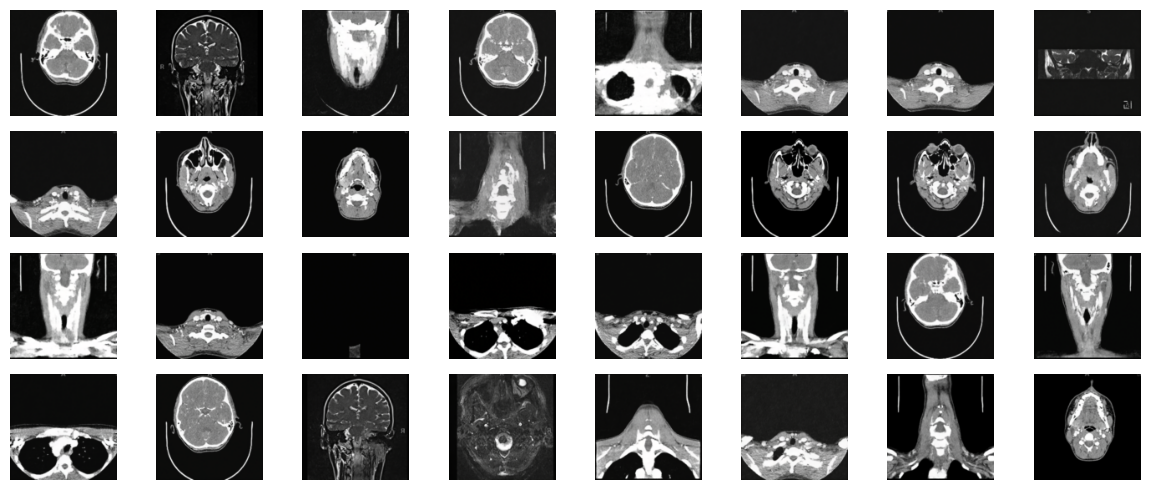

In [23]:
#@title Load model and plot some examples

# Load the saved model weights
model.load_weights("/content/models/ddpm.weights.h5")
# Generate and plot some samples
model.plot_images(num_rows=4, num_cols=8)

Generating images with labels:


100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


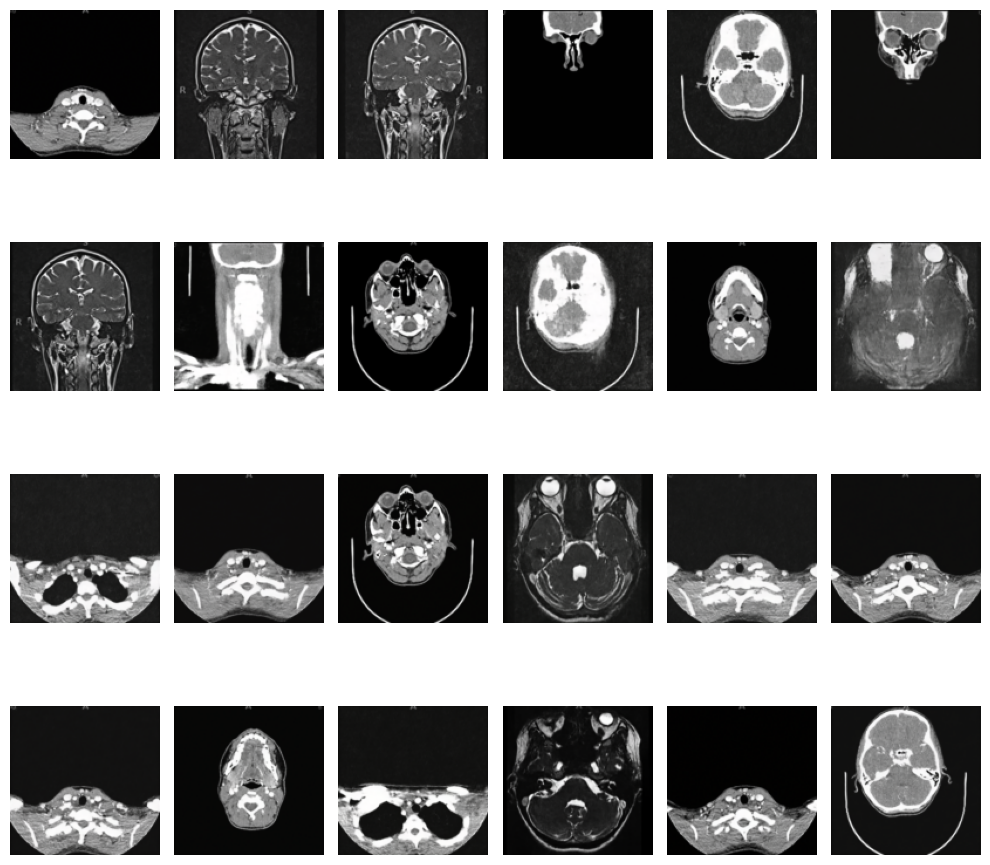

Images saved to generated_images


In [31]:
#@title Feeding labels

# Create a set of class labels
num_classes = 4 # This can be changed to higher number
class_labels = tf.range(num_classes, dtype=tf.int32)

# Based on generate_images function
# Adapted to include labels
def generate_img_labels(model, class_labels, num_images_per_class=6):
    print("Generating images with labels:")

    label_samples = []
    for class_label in class_labels:
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images_per_class, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the (EMA!) model iteratively
        for t in tqdm.tqdm(reversed(range(0, model.timesteps)), total=model.timesteps):
            # create a batch with one timestep
            tt = tf.cast(tf.fill(num_images_per_class, t), dtype=tf.int64)
            # predict the noise for the batch of noisy images
            pred_noise = model.ema_network.predict(
                [samples, tt, tf.fill(num_images_per_class, class_label)], verbose=0, batch_size=num_images_per_class
            )
            # update the noisy images by removing the noise
            samples = model.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        label_samples.append(samples)

    # Concatenate all samples
    label_samples = tf.concat(label_samples, axis=0)
    return label_samples


# The generated samples for each class are collected and concatenated into a single tensor
generated_samples = generate_img_labels(model, class_labels, num_images_per_class=6)

# Plot the generated samples
def plot_img_labels(samples, num_classes, num_images_per_class, figsize=(10, 10)):
    samples = tf.clip_by_value(samples * 127.5 + 127.5, 0.0, 255.0).numpy().astype(np.uint8)
    _, ax = plt.subplots(num_classes, num_images_per_class, figsize=figsize)
    for i in range(num_classes):
        for j in range(num_images_per_class):
            ax[i, j].imshow(samples[i * num_images_per_class + j])
            ax[i, j].axis("off")
    plt.tight_layout()
    plt.show()

plot_img_labels(generated_samples, num_classes, num_images_per_class=6)

# Save output
save_dir = "generated_images"
save_dir = pathlib.Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

def save_samples(samples, num_classes, num_images_per_class, save_dir):
    # Clip and convert samples to uint8 format
    samples = tf.clip_by_value(samples * 127.5 + 127.5, 0.0, 255.0).numpy().astype(np.uint8)

    # Save images in class-specific directories
    for i in range(num_classes):
        class_dir = save_dir / f"class_{i}"  # Use / to join paths
        class_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

        for j in range(num_images_per_class):
            img_array = samples[i * num_images_per_class + j]
            img = Image.fromarray(img_array)
            img.save(class_dir / f"image_{j + 1}.png")  # Use / to join paths

    print(f"Images saved to {save_dir}")

# Generate and save the images
save_samples(generated_samples, num_classes, num_images_per_class=6, save_dir=save_dir)



Generating a single image with two classes:


100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]


Blended image saved to generated_images/blended_image.png


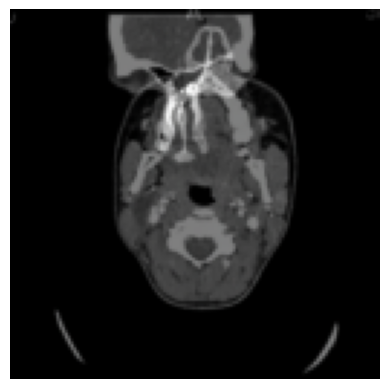

In [37]:
#@title One Image = Two Classes

# Save output of blended image
blended_image_save_path = save_dir / "blended_image.png"

def mixed_image(model, class_1, class_2, blend_ratio=0.5):
    print("Generating a single image with two classes:")

    # 1. Randomly sample noise (starting point for reverse process)
    samples1 = tf.random.normal(
        shape=(1, img_size, img_size, img_channels), dtype=tf.float32
    )
    samples2 = tf.random.normal(
        shape=(1, img_size, img_size, img_channels), dtype=tf.float32
    )

    # 2. Sample from the (EMA!) model iteratively
    for t in tqdm.tqdm(reversed(range(0, model.timesteps)), total=model.timesteps):
        # create a batch with one timestep
        tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
        # predict the noise for the batch of noisy images
        pred_noise1 = model.ema_network.predict(
            [samples1, tt, tf.fill(1, class_1)], verbose=0, batch_size=1
        )
        pred_noise2 = model.ema_network.predict(
            [samples2, tt, tf.fill(1, class_2)], verbose=0, batch_size=1
        )
        # update the noisy images by removing the noise
        samples1 = model.gdf_util.p_sample(
            pred_noise1, samples1, tt, clip_denoised=True
        )
        samples2 = model.gdf_util.p_sample(
            pred_noise2, samples2, tt, clip_denoised=True
        )

    # Blend the two samples
    # Linear interpolation
    blended_image = blend_ratio * samples1 + (1 - blend_ratio) * samples2
    return blended_image

# Set classes and blend
class_1 = 1
class_2 = 3
blended_image = mixed_image(model, class_1, class_2, blend_ratio=0.5)

# Save blended image
def save_blended_image(image, save_path):
    # Clip and convert the image to uint8
    image = tf.clip_by_value(image[0] * 127.5 + 127.5, 0.0, 255.0).numpy().astype(np.uint8)
    img = Image.fromarray(image)
    img.save(save_path)
    print(f"Blended image saved to {save_path}")

save_blended_image(blended_image, blended_image_save_path)

# Display blended image
plt.imshow(tf.clip_by_value(blended_image[0] * 127.5 + 127.5, 0.0, 255.0).numpy().astype(np.uint8))
plt.axis("off")
plt.show()


#Conclusion

The key to implement the class conditional in this case was tensor compability. By reshaping and expanding the class embeddings to match the spatial dimensions of the input images, the model was able to leverage class information during training. The class embeddings were produced using a learnable embedding layer, which maps discrete class indices to dense vectors, then reshaped and broadcasted to align with the spatial dimensions of the image inputs before being concatenated as additional channels.

Initially, attempts to use direct indexing on the inputs (images, class_labels = inputs) within the custom train_step method resulted in an OperatorNotAllowedInGraphError. This because symbolic tensors, which represent placeholders or operations in TensorFlow's static computational graph, cannot be directly iterated or indexed. It was fixed by instead of relying on direct indexing, the inputs were structured to pass through the model and training functions in a graph-compatible manner.

At first the model was trained using a batch size of 64 for 50 epochs, which proved sufficient to achieve good performance on the dataset, althogh the quality of the samples were not good enogh.
The key was to change the image shape to 128, allowing the model to capture finer spatial details.

Further exploration of hyperparameters can result in a very high-quality generated image, something I would have liked to do if I had more computing resources.


# References

- Making a Class-Conditioned Diffusion Model - Hugging Face Diffusion Course (no date). Available at: https://huggingface.co/learn/diffusion-course/en/unit2/3 (Accessed: 24 December 2024).


- Team, K. (no date) Keras documentation: The Model class. Available at: https://keras.io/api/models/model/ (Accessed: 24 December 2024).


- user3877422 (2023) ‘How to create a video from images with FFmpeg?’, Stack Overflow. Available at: https://stackoverflow.com/q/24961127 (Accessed: 24 December 2024).




In [42]:
!jupyter nbconvert --to html //content/drive/MyDrive/AI_project/the_cerebro.ipynb --output /content/drive/MyDrive/the_cerebro.html

[NbConvertApp] Converting notebook //content/drive/MyDrive/AI_project/the_cerebro.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][26]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'Generating images:\n'}
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 2895839 bytes to /content/drive/MyDrive/the_cerebro.html
